In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

# LDA Modeling
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## 1. Read data and tokenize reply_body

In [54]:
data = pd.read_csv('preprocessed.csv')

In [55]:
data.shape

(6149, 10)

In [286]:
data['submission_link_flair_text'].fillna("None",inplace=True);

In [59]:
data['reply_tokenized']=[word_tokenize(word) for word in data['reply_body']]

## 2. Filter tokens to contain only nouns

In [295]:
# Exploring pos_tag for a single reply_tokenized:
[pos for pos in nltk.pos_tag(data['reply_tokenized'][0])]


[('get', 'VB'),
 ('ton', 'NN'),
 ('bug', 'NN'),
 ('well', 'RB'),
 ('snappi', 'JJ'),
 ('line', 'NN'),
 ('respons', 'NNS'),
 ('time', 'NN'),
 ('reason', 'NN'),
 ('abil', 'JJ'),
 ('sync', 'NN'),
 ('googl', 'NN'),
 ('drive', 'NN'),
 ('download', 'NN'),
 ('multipl', 'NN'),
 ('file', 'NN'),
 ('googl', 'NN'),
 ('drive', 'NN'),
 ('gone', 'VBN'),
 ('think', 'VBP'),
 ('need', 'JJ'),
 ('time', 'NN'),
 ('cope', 'VB'),
 ('new', 'JJ'),
 ('launch', 'NN')]

In [296]:
# Now trying to filter Nouns only

def filterNouns(text):
    return [pos[0] for pos in nltk.pos_tag(text) if pos[1]=='NN']

filterNouns(data['reply_tokenized'][0])

['ton',
 'bug',
 'line',
 'time',
 'reason',
 'sync',
 'googl',
 'drive',
 'download',
 'multipl',
 'file',
 'googl',
 'drive',
 'time',
 'launch']

In [297]:
# Now filtering the entire dataSet:
data['reply_noun_token']=data['reply_tokenized'].apply(filterNouns)

In [298]:
data['submission_link_flair_text'].unique()

array(['None', 'Review', 'Question - iPad', 'Question - Other',
       'Question - Mac', 'Stylus problems', 'Templates',
       'Question - iPhone'], dtype=object)

## 3. Split the DataFrame into multiple DataFrames by the value in the submission_link_flair_text column

In [299]:
type(data.submission_link_flair_text.value_counts())

pandas.core.series.Series

In [300]:
data.submission_link_flair_text.value_counts()

None                 3974
Question - iPad      1061
Templates             486
Question - Other      249
Review                220
Question - Mac         61
Stylus problems        53
Question - iPhone      45
Name: submission_link_flair_text, dtype: int64

In [301]:
flair_text_labels = data['submission_link_flair_text'].unique();
multipleDataframes = []
for fText in flair_text_labels:
    
    # nan protection
    if type(fText)!= str:
        multipleDataframes.append(data[data['submission_link_flair_text'].isna()])
        continue
    multipleDataframes.append(data[data['submission_link_flair_text']==fText])
    

## 4. For each topic, pick one of the plots and generate it using the reply_tokenized column

In [302]:
def plotWordCloud(df, topicName):
    allTokensStr = " ".join(np.hstack(df['reply_tokenized']))
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(allTokensStr)
    plt.figure(figsize=(15,8))
    plt.title("Word Cloud for topic: %s"%topicName, fontsize=20)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

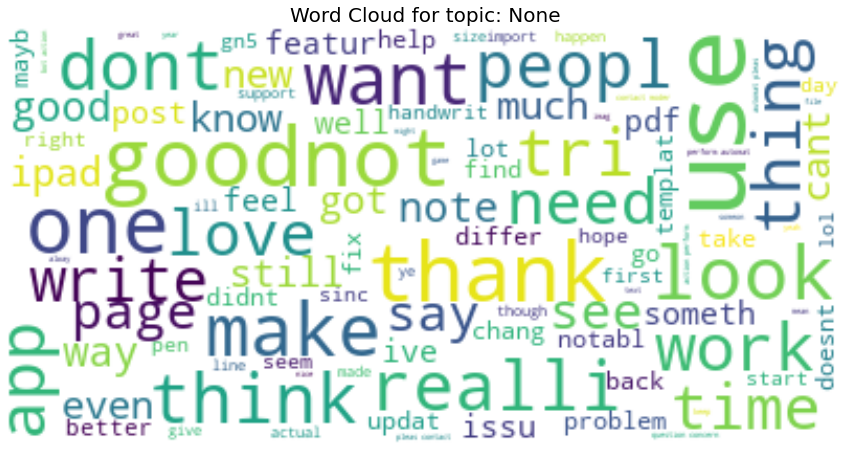

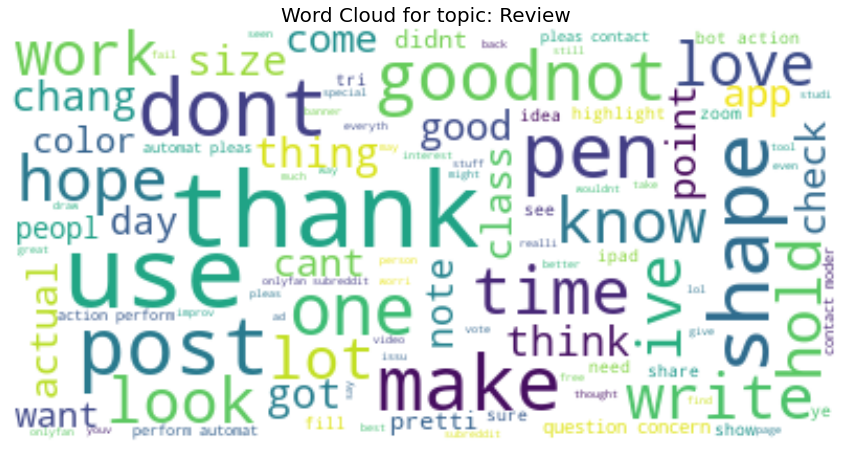

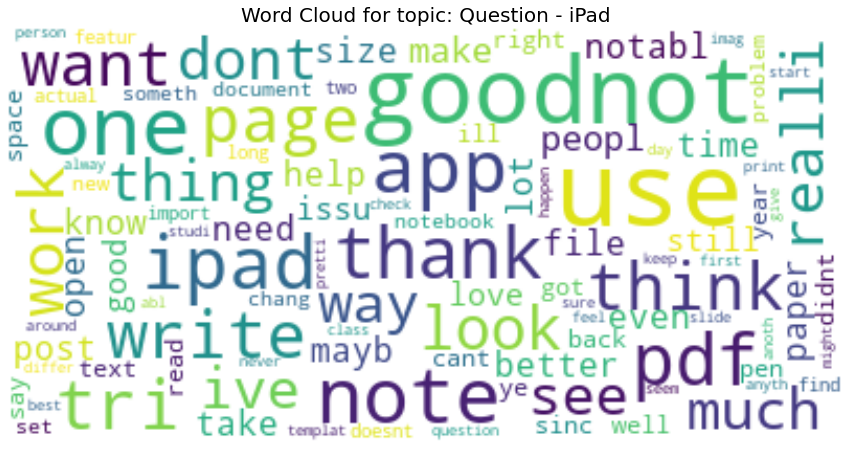

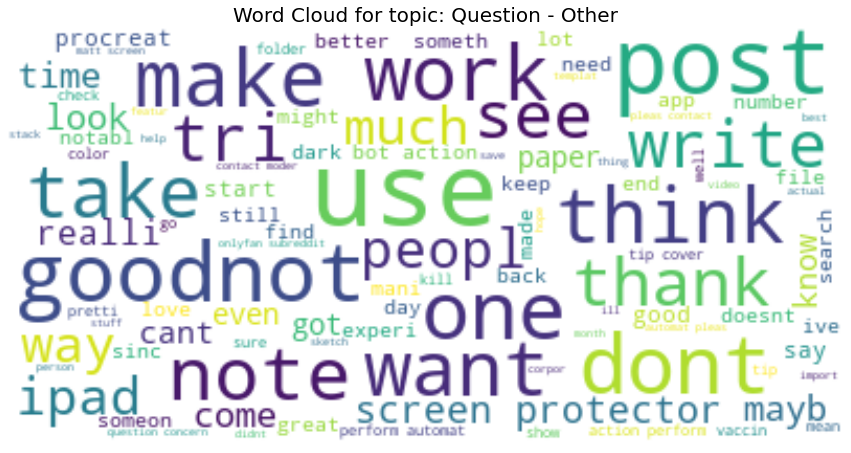

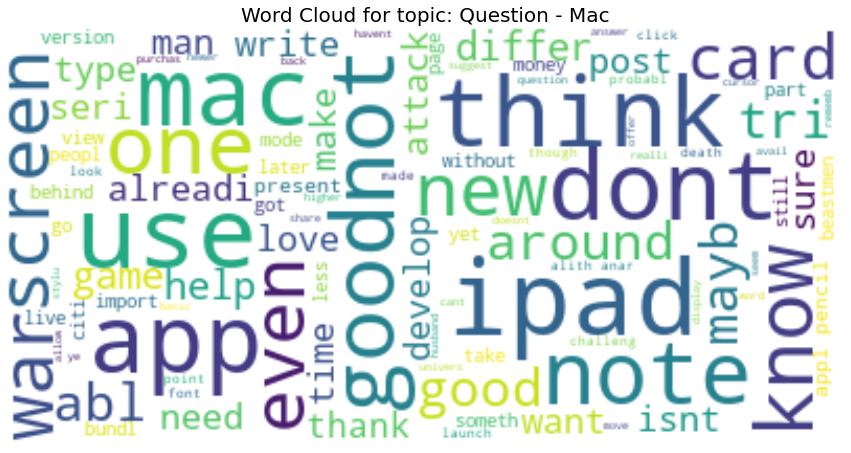

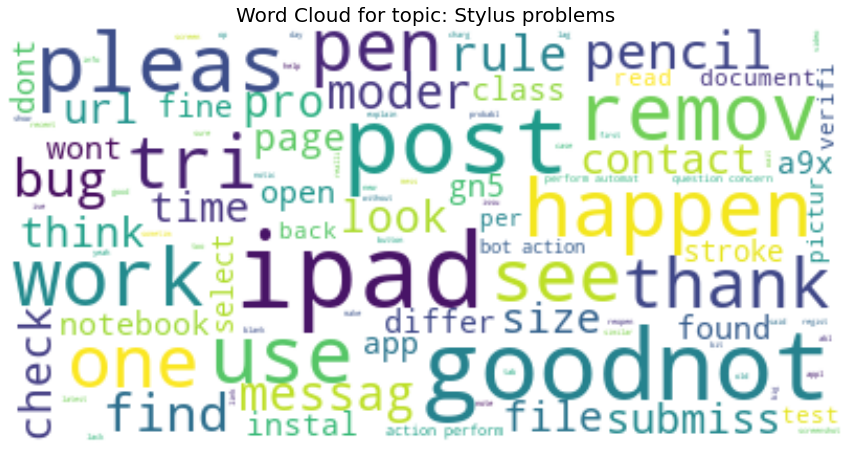

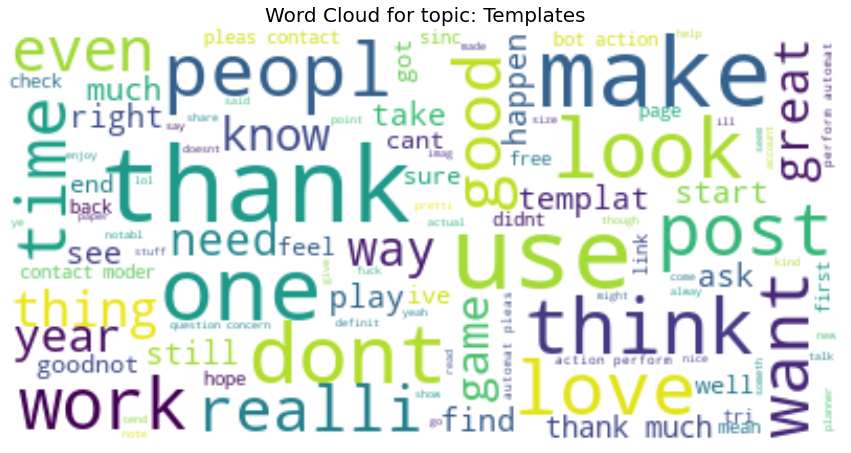

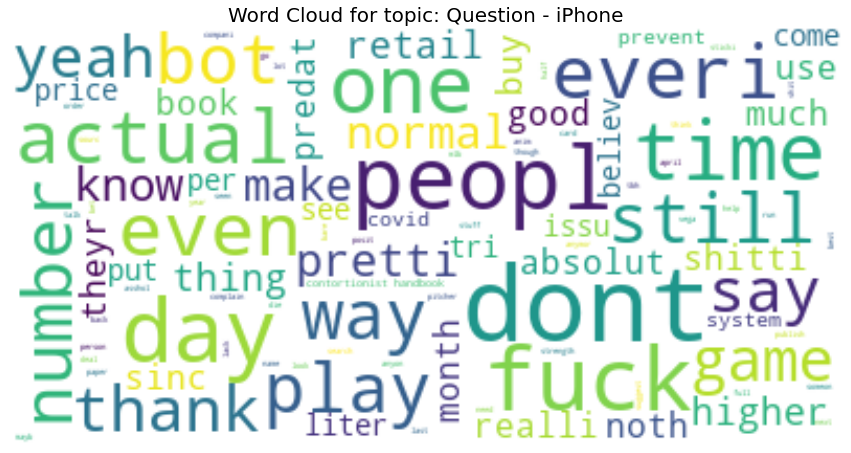

In [303]:
for i in range(len(flair_text_labels)):
    plotWordCloud(multipleDataframes[i],flair_text_labels[i])

In [304]:
def plotTopWords(df, topicName, n=10):
    word_could_dict=Counter(np.hstack(df['reply_tokenized']))
    word_could_dict.most_common(n)

    top_words = pd.DataFrame(word_could_dict.most_common(n),columns=['word','count'])

    plt.figure(figsize=(15,7))
    plt.title("Top %d words (Topic: %s)"%(n,topicName))
    ax=sns.barplot(x="word", y="count", data=top_words)
    plt.plot()

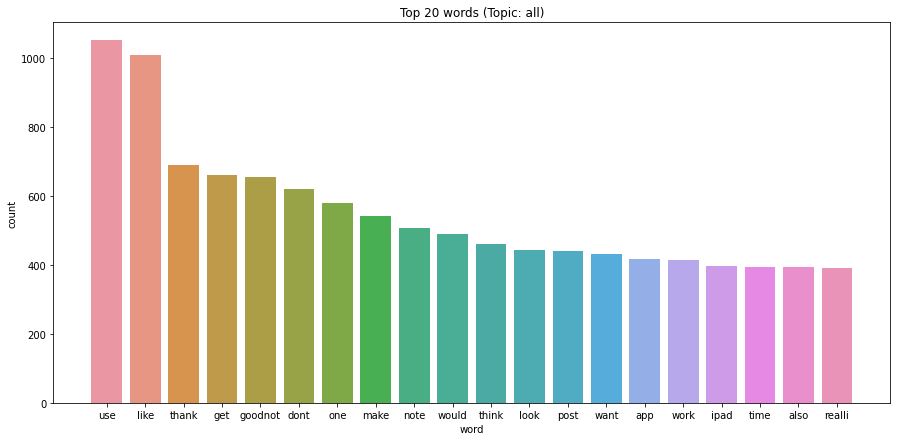

In [305]:
plotTopWords(data,"all", n=20)

In [306]:
# looking at top bigram
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n):
    vec = CountVectorizer(tokenizer=lambda text: text,
                          ngram_range=(n, n),
                         lowercase=False).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

def graph_ngrams(df, title, topn=30, ngram=1,axis_num=0):
    corpus = df['reply_tokenized']
    top_n_bigrams=get_top_ngram(corpus, ngram)[:topn]
    x,y=map(list,zip(*top_n_bigrams))
    axs[axis_num].set_title("(Topic: %s)"%title)
    sns.barplot(x=y,y=x,ax=axs[axis_num])

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


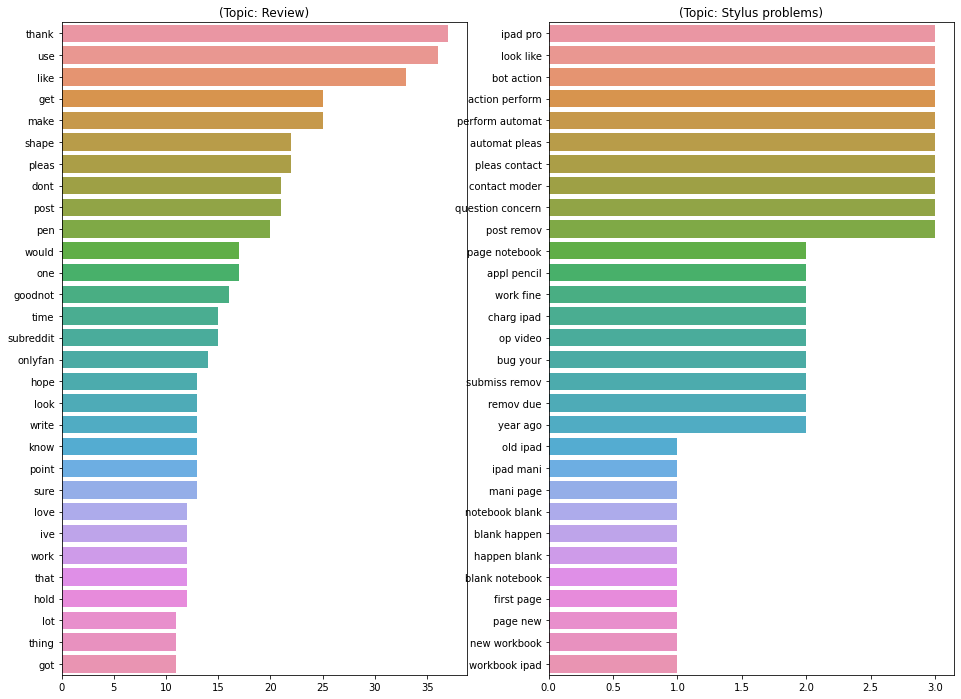

In [328]:
fig, axs = plt.subplots(1,2,figsize=(16,12))

graph_ngrams(multipleDataframes[1], flair_text_labels[1], ngram=1,axis_num=0)
graph_ngrams(multipleDataframes[5], flair_text_labels[5], ngram=2,axis_num=1)


/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


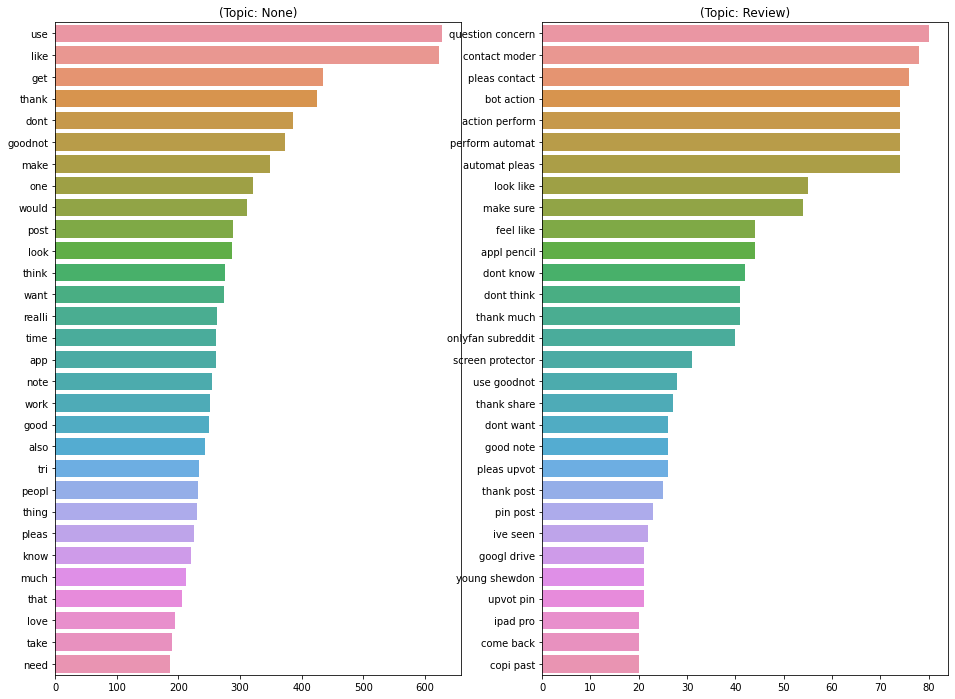

In [307]:
fig, axs = plt.subplots(1,2,figsize=(16,12))

graph_ngrams(multipleDataframes[0], flair_text_labels[0], ngram=1,axis_num=0)
graph_ngrams(multipleDataframes[0], flair_text_labels[1], ngram=2,axis_num=1)


/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


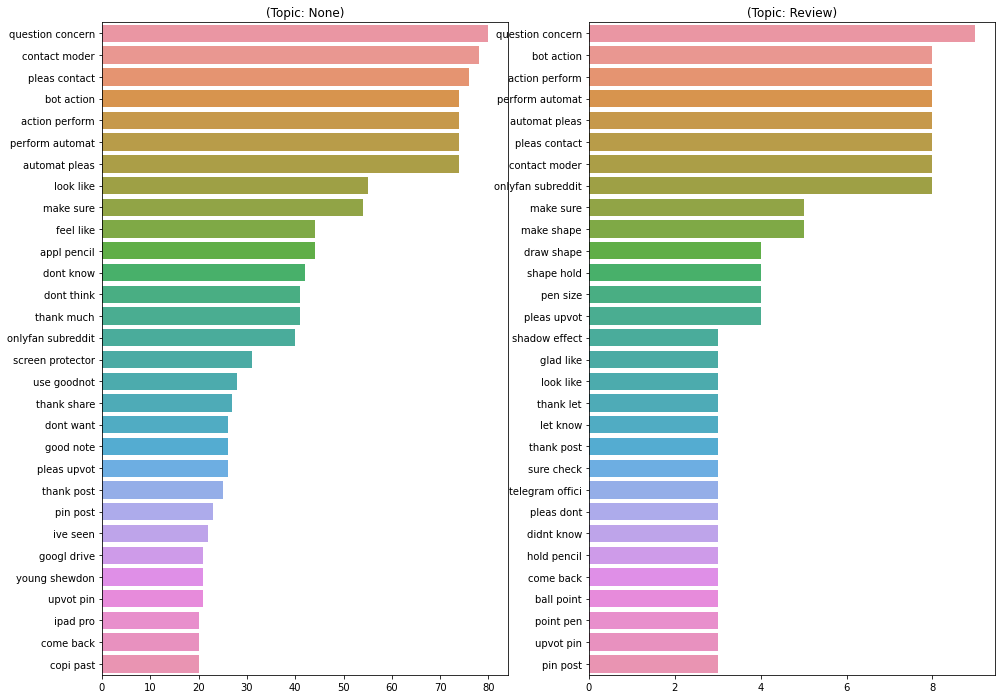

In [308]:
fig, axs = plt.subplots(1,2,figsize=(16,12))

graph_ngrams(multipleDataframes[0], flair_text_labels[0], ngram=2,axis_num=0)
graph_ngrams(multipleDataframes[1], flair_text_labels[1], ngram=2,axis_num=1)


/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


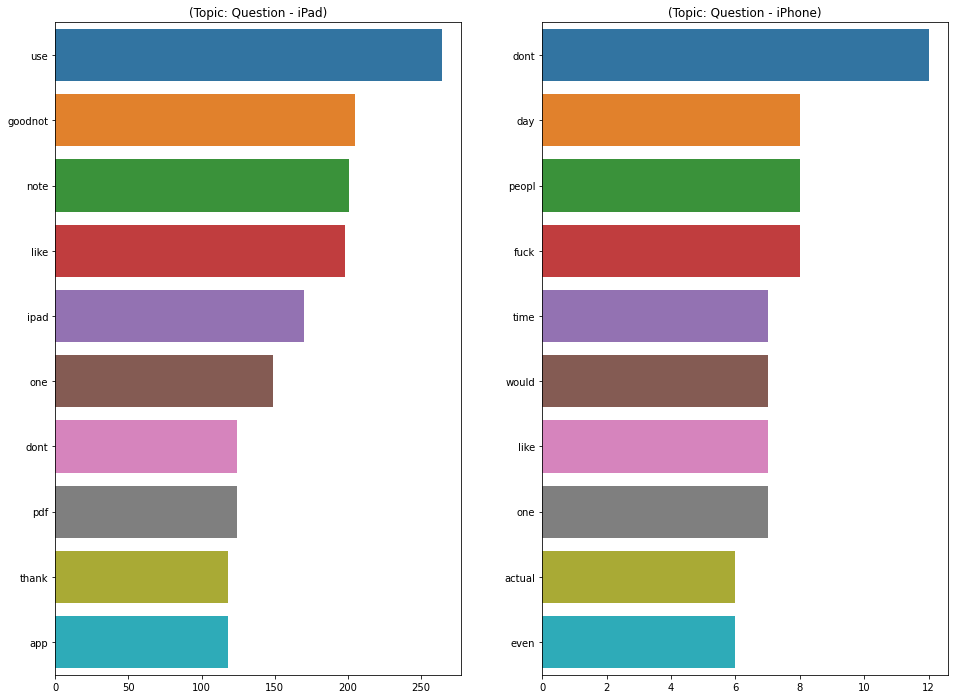

In [330]:
fig, axs = plt.subplots(1,2,figsize=(16,12))

graph_ngrams(multipleDataframes[2], flair_text_labels[2], ngram=1,axis_num=0, topn=10)
graph_ngrams(multipleDataframes[7], flair_text_labels[7], ngram=1,axis_num=1, topn=10)


/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


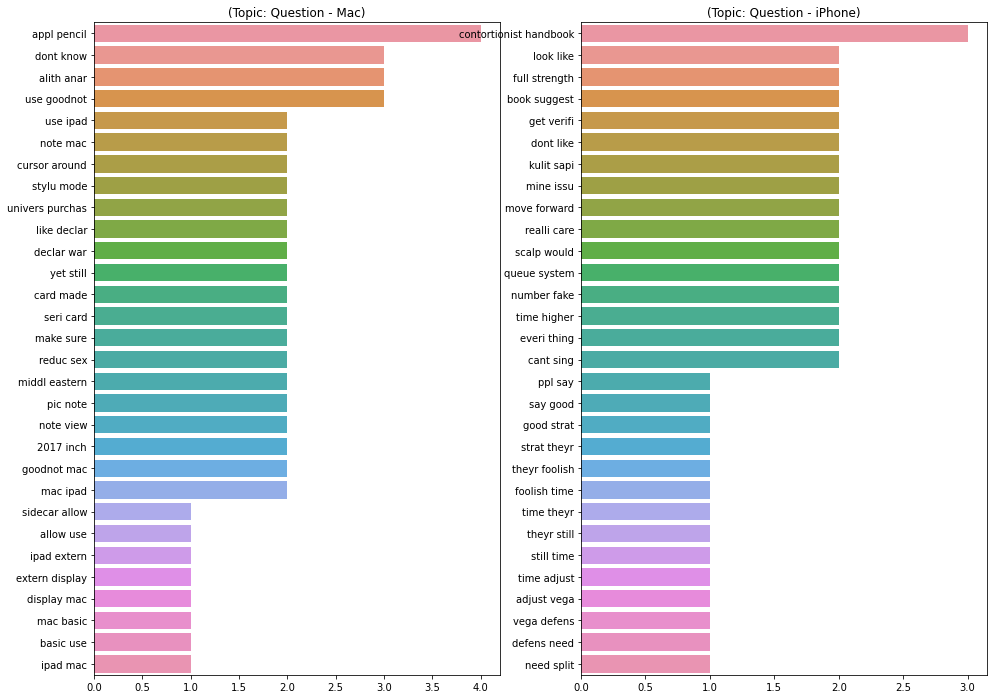

In [310]:
fig, axs = plt.subplots(1,2,figsize=(16,12))

graph_ngrams(multipleDataframes[4], flair_text_labels[4], ngram=2,axis_num=0)
graph_ngrams(multipleDataframes[7], flair_text_labels[7], ngram=2,axis_num=1)


/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


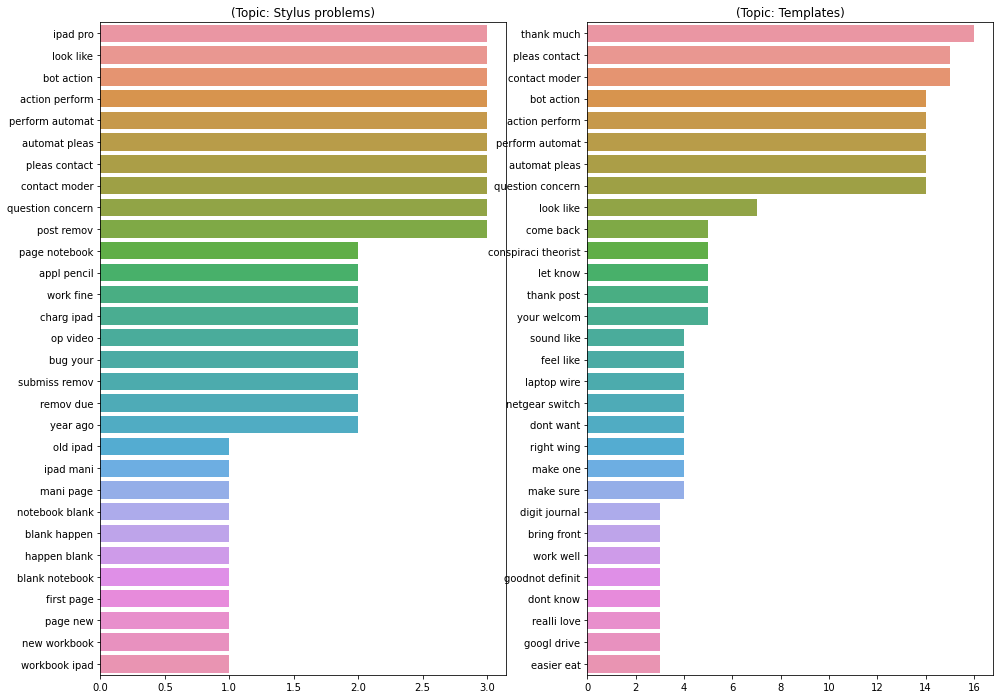

In [311]:
fig, axs = plt.subplots(1,2,figsize=(16,12))

graph_ngrams(multipleDataframes[5], flair_text_labels[5], ngram=2,axis_num=0)
graph_ngrams(multipleDataframes[6], flair_text_labels[6], ngram=2,axis_num=1)


## 5. Observations for each topic:

* none - Majority of replies had no topic! Words 'Use' and 'Like' are the most prevailing (in fact these words are pretty common for other topics as well, so no important observations for topic none
* 'Review' - Word 'Thank' is the most commonly used for Reviews whereas it's not that common for other topics. No negative words among the most commonly used ones, so perhaps people are overrally happy in their reviews.
* 'Question IPad' - Prevailing words: use and goodnote, Interesting observation that word ipad and app is appearing pretty commonly (For other products name of the product doesn't appear that often)
* 'Question IPhone' - Word don't is the most prevailing, some other words that might indicate frustraighted customers noticed among the most common words. Perhaps people are not super happy about IPhone version of the app.
* 'Question - Mac' - Like, Get, Use - prevailing words, good indicator of happy customers. Was interesting to see word ipad among the most used words, wondering if product for Mac was compared to ipad a lot!
* 'Question - Other' - Words 'Like', 'Use', 'Get' similarly to presence in other topics. Word 'screen' is a new word that doesn't seem to appear among most commonly used words in other topics. 
* 'Stylus problems'- 'IPad', 'GoodNote' among the most prevailing words, indicator of where the problems are occuring. Interesing observation - word 'Try', perhaps some users listed set of actions that they tried before.
* 'Templates' - 'Like', 'Thanks', 'Use' - not new words, but indicators of happy customers.

## 6. LDA Topic Modeling

In [316]:
# Picking a topic: 
idx = np.where(flair_text_labels=='None')[0][0]
topicDf = multipleDataframes[idx] 

In [317]:
# Constructing dictionary
dictionary = corpora.Dictionary(topicDf['reply_noun_token'])

In [318]:
# Converting to doc2vecs
doc_term_matrix = [dictionary.doc2bow(doc) for doc in topicDf['reply_noun_token']]

#### Optimize # of k topics
LDA requires that we specify the number of topics that exists in a corpus of text. There are several common measures that can be optimized, such as predictive likelihood, perplexity, and coherence. Much literature has indicated that maximizing coherence, particularly a measure named Cv (https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), leads to better human interpretability. This measure assesses the interpretability of topics given the set of words in generated topics. Therefore, we will optimize this measure.

Since eval_only calculates perplexity metric, we can set it to None to save time, as we will use a different metric called Cv.

In [319]:
coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=topicDf['reply_noun_token'],\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


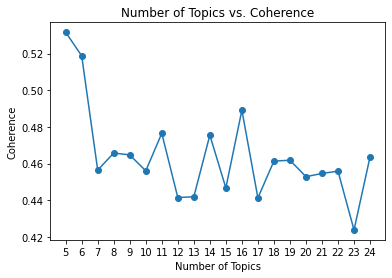

In [320]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

Trying number of topics that is near 2 local maximas to see what shows best results since it's not always where the highest Cv is

So let's pick 12 and 23

In [321]:
lda1 = gensim.models.ldamodel.LdaModel
ldamodel1 = lda1(doc_term_matrix, num_topics=5, id2word = dictionary, passes=40,\
                iterations=200,  chunksize = 10000, eval_every = None, random_state=0)
    
lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = lda2(doc_term_matrix, num_topics=16, id2word = dictionary, passes=40,\
                iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

Some explanation of the parameters that can be tuned:

Passes: The number of times model iterates through the whole corpus
Iterations: The number of iterations the model trains on each pass
Chunk size: Number of rows that are taken to train the model each
Other explanation of parameters: https://radimrehurek.com/gensim/models/ldamodel.html

In [322]:
ldamodel2.show_topics(23, num_words=10, formatted=False)

[(0,
  [('thing', 0.011116638),
   ('time', 0.009691956),
   ('fix', 0.009259476),
   ('list', 0.008620363),
   ('day', 0.008531749),
   ('work', 0.0082437815),
   ('team', 0.008136927),
   ('idea', 0.008032823),
   ('request', 0.007889781),
   ('friend', 0.0075270664)]),
 (1,
  [('app', 0.03306348),
   ('drive', 0.019593045),
   ('hate', 0.011008176),
   ('awesom', 0.010421242),
   ('fuck', 0.00979499),
   ('googl', 0.009596345),
   ('use', 0.00939608),
   ('mac', 0.008824781),
   ('issu', 0.008753099),
   ('bug', 0.008148047)]),
 (2,
  [('realli', 0.021976965),
   ('thing', 0.02136206),
   ('time', 0.019316362),
   ('day', 0.013939242),
   ('peopl', 0.013891676),
   ('dont', 0.01150396),
   ('worri', 0.009850193),
   ('stuff', 0.009737677),
   ('probabl', 0.009143011),
   ('part', 0.008636868)]),
 (3,
  [('question', 0.041497968),
   ('post', 0.040127795),
   ('concern', 0.0337544),
   ('automat', 0.033444077),
   ('moder', 0.033255477),
   ('perform', 0.0305851),
   ('action', 0.029

## 7. Visualize LDA Model

#### Relevancy
Sometimes, words that are ranked as top words for a given topic may be ranked high because they are globally frequent across text in a corpus. Relevancy score helps to prioritize terms that belong more exclusively to a given topic. This can increase interpretability even more. The relevance of term w to topic k is defined as:

r(w,k|λ)=λlog(ϕkw)+(1−λ)log(ϕkwpkw) 
where  ϕkw  is the probability of term w in topic k and  ϕkwpkw  is lift in term's probability within a topic to its marginal probability across the corpus (this helps discards globally frequent terms). A lower lambda value gives more importance to the second term, which gives more importance to topic exclusivity. We can use Python’s pyLDAvis for this.

Paper behind this tool: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [331]:
topic_data =  gensimvis.prepare(ldamodel1, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [324]:
def getTopicContent(topic_data,lambd=1):
    all_topics = {}
    num_terms = 10 # Adjust number of words to represent each topic
    # Adjust lambd accordingly based on tuning above
    for i in range(1,100): #Adjust this to reflect number of topics chosen for final LDA model
        topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
        if (len(topic)==0):
            break;
        topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
        all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

    return pd.DataFrame(all_topics).T

In [325]:
getTopicContent(topic_data, lambd=0.8)

,0,1,2,3,4,5,6,7,8,9
Topic 1,use,goodnot,page,thing,note,pdf,size,work,dont,time
Topic 2,thank,look,app,love,problem,ye,gn4,use,tri,featur
Topic 3,post,question,concern,automat,moder,rule,perform,action,comment,remov
Topic 4,handwrit,onlyfan,note,subreddit,day,watch,thing,video,time,welcom
Topic 5,text,shewdon,ampx200b,time,box,link,use,work,help,letter


In [326]:
topic_data2 =  gensimvis.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data2)

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [332]:
getTopicContent(topic_data2)

,0,1,2,3,4,5,6,7,8,9
Topic 1,goodnot,use,note,page,pdf,size,file,paper,ipad,work
Topic 2,dont,use,problem,gn4,get,gn5,thing,work,link,time
Topic 3,question,post,concern,automat,moder,perform,action,comment,subreddit,remov
Topic 4,realli,thing,time,day,peopl,dont,worri,stuff,probabl,part
Topic 5,thank,time,share,tri,imag,work,zoom,ill,dont,look
Topic 6,post,rule,use,dont,pin,tri,look,age,palm,bookmark
Topic 7,look,watch,thing,beauti,way,name,man,play,doesnt,use
Topic 8,ye,subreddit,onlyfan,end,post,protector,lot,screen,day,reddit
Topic 9,shewdon,ampx200b,show,welcom,time,mowti,maw,watch,cwaim,youw
Topic 10,thing,time,fix,list,day,work,team,idea,request,friend


/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp im

## 8. Eport LDA visualization as HTML

Picking ladmodel1, eventhough ldamodel2 also seem to be pretty well distanced from eachother, but it's easier to eyeball smaller number of topics

In [247]:
pyLDAvis.save_html(topic_data, 'lda.html')